Outline based on Jose Celis' "lstm-val_v2.ipynb"

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import numpy as np, pandas as pd
from black_scholes import BlackScholesModel
from heston import HestonModel


In [16]:
import matplotlib.pyplot as plt

def plotprices(pred_df):
  plt.figure(figsize=(12, 6))

  # Plot predictions (yhat)
  plt.plot(pred_df["valuation_date"], pred_df["yhat"], label="Predicted (yhat)", linewidth=2)

  # Plot true values (y_true)
  plt.plot(pred_df["valuation_date"], pred_df["y_true"], label="Actual (y_true)", linewidth=2)

  # Formatting
  plt.xlabel("Valuation Date")
  plt.ylabel("Option Price")
  plt.title("Predicted vs Actual Option Prices Over Time")
  plt.legend()
  plt.grid(True)

  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

In [17]:
#df = pd.read_csv("../data/data.csv", nrows=1000000, low_memory=False, index_col=0)


# use_cols = ["QUOTE_DATE", "UNDERLYING_LAST", "STRIKE", "EXPIRE_DATE", "C_BID", "VOL_GG", "RFR", "DTE"]
use_cols = ["QUOTE_DATE", "EXPIRE_DATE", "STRIKE", "UNDERLYING_LAST", "DTE", "VOL_90D", "VOL_GG", "RFR", "C_BID", "C_ASK", "LONGTERM_AVG_VOL", "VOL_OF_VOL", "STR_MEAN_REVERSION", "CORRELATION", "LONGTERM_AVG_VOL_GG", "VOL_OF_VOL_GG", "STR_MEAN_REVERSION_GG", "CORRELATION_GG"]
# BS needs current_price, exercise_price, time_to_maturity (years), volatility, and risk_free_rate

chunks = []

for chunk in pd.read_csv("data/data.csv", chunksize=200_000, usecols=use_cols, low_memory=False):
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)
df['QUOTE_DATE'] = pd.to_datetime(df['QUOTE_DATE'])

df.head()

,QUOTE_DATE,UNDERLYING_LAST,EXPIRE_DATE,DTE,C_BID,C_ASK,STRIKE,RFR,VOL_90D,LONGTERM_AVG_VOL,VOL_OF_VOL,STR_MEAN_REVERSION,CORRELATION,VOL_GG,LONGTERM_AVG_VOL_GG,VOL_OF_VOL_GG,STR_MEAN_REVERSION_GG,CORRELATION_GG
0,2022-04-01,4545.81,2022-04-01,0.0,3736.20,3754.50,800.0,0.15,0.258858,0.203385,0.181666,0.184902,-0.5,0.240809,0.191398,0.574171,2.140913,-0.5
1,2022-04-01,4545.81,2022-07-15,105.0,1.45,1.60,5375.0,0.53,0.258858,0.203385,0.181666,0.184902,-0.5,0.240809,0.191398,0.574171,2.140913,-0.5
2,2022-04-01,4545.81,2022-07-15,105.0,1.65,1.85,5350.0,0.53,0.258858,0.203385,0.181666,0.184902,-0.5,0.240809,0.191398,0.574171,2.140913,-0.5
3,2022-04-01,4545.81,2022-07-15,105.0,1.85,2.05,5325.0,0.53,0.258858,0.203385,0.181666,0.184902,-0.5,0.240809,0.191398,0.574171,2.140913,-0.5
4,2022-04-01,4545.81,2022-07-15,105.0,2.05,2.35,5300.0,0.53,0.258858,0.203385,0.181666,0.184902,-0.5,0.240809,0.191398,0.574171,2.140913,-0.5


In [18]:
# # Testing old and new data csvs


# use_cols = ["QUOTE_DATE", "EXPIRE_DATE", "STRIKE", "UNDERLYING_LAST", "DTE", "VOL_90D", "VOL_GG", "RFR", "C_BID", "C_ASK"]
# # BS needs current_price, exercise_price, time_to_maturity (years), volatility, and risk_free_rate

# chunks = []

# for chunk in pd.read_csv("data_new.csv", chunksize=200_000, usecols=use_cols, low_memory=False):
#     chunks.append(chunk)

# df_new = pd.concat(chunks, ignore_index=True)
# df_new['QUOTE_DATE'] = pd.to_datetime(df_new['QUOTE_DATE'])

# df_new.head()

# Performance Metrics

In [23]:
def calculate_pimentel_metrics(y_true, y_pred):
    """
    Calculate performance metrics from Pimentel et al. paper.

    Args:
        y_true: actual values (tensor)
        y_pred: predicted values (tensor)

    Returns:
        dict with Theil U1, Bias proportion, Variance proportion, Covariance proportion
    """

    # Convert to numpy for calculations
    y_true = y_true.to_numpy().flatten()
    y_pred = y_pred.to_numpy().flatten() # took out .cpu() after variable, also changed numpy() to to_numpy()

    m = len(y_true)

    # Theil U1 (Equation 27)
    mse = (1 / m) * np.sum((y_true - y_pred) ** 2)
    numerator = np.sqrt(mse)
    denominator = np.sqrt((1 / m) * np.sum(y_true**2))
    theil_u1 = numerator / denominator

    # Mean and std of actual and predicted
    y_mean = y_true.mean()
    y_hat_mean = y_pred.mean()
    sigma_y = y_true.std(ddof=0)
    sigma_y_hat = y_pred.std(ddof=0)

    # Correlation coefficient
    rho = np.corrcoef(y_true, y_pred)[0, 1]

    # Bias proportion (Equation 28) - squared difference in means
    bias_prop = (y_hat_mean - y_mean) ** 2 / mse

    # Variance proportion (Equation 29) - squared difference in standard deviations
    var_prop = (sigma_y_hat - sigma_y) ** 2 / mse

    # Covariance proportion (Equation 30) - unsystematic error
    cov_prop = 2 * (1 - rho) * sigma_y_hat * sigma_y / mse

    return {
        "theil_u1": theil_u1,
        "bias_prop": bias_prop,
        "var_prop": var_prop,
        "cov_prop": cov_prop,
    }

# Black Scholes Predictions

In [24]:
bs_model = BlackScholesModel()

# Just add the black scholes prediction to the df at each row. For BS I just need current_price, exercise_price, time_to_maturity (years), volatility, and risk_free_rate


# use_cols = ["QUOTE_DATE", "EXPIRE_DATE", "STRIKE", "UNDERLYING_LAST", "DTE", "VOL_90D", "VOL_GG", "RFR", "C_BID"]

# Change time to years
df["T_TO_EXPIRY_YEARS"] = df["DTE"] / 365.25

# I believe I change the RFR to a number, not a percentage
df["RFR_NUM"] = df["RFR"] / 100

df["BS_PRICE"] = bs_model.predicted_call_price_vectorized(
    current_price=df["UNDERLYING_LAST"].to_numpy(),
    exercise_price=df["STRIKE"].to_numpy(),
    time_to_maturity=df["T_TO_EXPIRY_YEARS"].to_numpy(),
    volatility=df["VOL_90D"].to_numpy(),
    risk_free_rate=df["RFR_NUM"].to_numpy()
)

# Adding BS_PRICE_GG
df["BS_PRICE_GG"] = bs_model.predicted_call_price_vectorized(
    current_price=df["UNDERLYING_LAST"].to_numpy(),
    exercise_price=df["STRIKE"].to_numpy(),
    time_to_maturity=df["T_TO_EXPIRY_YEARS"].to_numpy(),
    volatility=df["VOL_GG"].to_numpy(),
    risk_free_rate=df["RFR_NUM"].to_numpy()
)

# Heston Predictions

In [25]:
# I'm going to need to figure out the exact inputs to heston and vectorize my heston implementation

heston_model = HestonModel()

# TODO double check that units make sense and that things are annualized

# Already have the T_TO_EXPIRY_YEARS and RFR_NUM
# I need to calculate these extra terms
# predicted_price = heston_model.predicted_call_price(
#     current_price = df["UNDERLYING_LAST"],
#     exercise_price=df["STRIKE"],
#     time_to_maturity=df["T_TO_EXPIRY_YEARS"],
#     risk_free_rate=df["RFR_NUM"], # Should check that this is annualized
#     initial_volatility=df["VOL_90D"] ** 2, # Pretty sure this needs to be squared. Also should convert ot annualized volatility
#     longterm_avg_vol= None, #TODO
#     vol_of_vol=None, # TODO
#     strength_of_mean_reversion= None, #TODO
#     correlation=None, #TODO
#     lambda_val=0.0
# )

dummy_np_arr = df["UNDERLYING_LAST"].to_numpy()
# test_longterm_avg_vol = np.full_like(dummy_np_arr, 0.20338457897531917 ** 2) # Calculated in preprocessing
# test_vol_of_vol = np.full_like(dummy_np_arr, 0.2)
# test_strength_of_mean_reversion = np.full_like(dummy_np_arr, 2)
# test_correlation = np.full_like(dummy_np_arr, -0.5)
test_lambda_val = np.zeros_like(dummy_np_arr)

# longterm_avg_vol should be the root mean square of the VOL_90D. Just a constant for all options


df["HESTON_PRICE"] = heston_model.predicted_call_price_vectorized(
    current_price = df["UNDERLYING_LAST"].to_numpy(),
    exercise_price=df["STRIKE"].to_numpy(),
    time_to_maturity=df["T_TO_EXPIRY_YEARS"].to_numpy(),
    risk_free_rate=df["RFR_NUM"].to_numpy(), # Should check that this is annualized
    initial_volatility=df["VOL_90D"].to_numpy() ** 2, # Pretty sure this needs to be squared. Also should convert ot annualized volatility
    longterm_avg_vol= df["LONGTERM_AVG_VOL"].to_numpy() ** 2,
    vol_of_vol=df["VOL_OF_VOL"].to_numpy(),
    strength_of_mean_reversion= df["STR_MEAN_REVERSION"].to_numpy(),
    correlation=df["CORRELATION"].to_numpy(),
    lambda_val=test_lambda_val,
    batch_size=50000,
    verbose=True    
)

pass
# After that I need to vectorize (if possible)
# Without vectorizing it takes 5.7 ms per prediction
# with 3.5 million rows it would be 5.5 hours naively (repeated again for GG volatility)
# Looks like it should take ~24 mins after the first vectoization/optimization. This is probably good enough
# (There are probably several optimizations I could use)

On batch 0 of 70
On batch 1 of 70
On batch 2 of 70
On batch 3 of 70
On batch 4 of 70
On batch 5 of 70
On batch 6 of 70
On batch 7 of 70
On batch 8 of 70
On batch 9 of 70
On batch 10 of 70
On batch 11 of 70
On batch 12 of 70
On batch 13 of 70
On batch 14 of 70
On batch 15 of 70
On batch 16 of 70
On batch 17 of 70
On batch 18 of 70
On batch 19 of 70
On batch 20 of 70
On batch 21 of 70
On batch 22 of 70
On batch 23 of 70
On batch 24 of 70
On batch 25 of 70
On batch 26 of 70
On batch 27 of 70
On batch 28 of 70
On batch 29 of 70
On batch 30 of 70
On batch 31 of 70
On batch 32 of 70
On batch 33 of 70
On batch 34 of 70
On batch 35 of 70
On batch 36 of 70
On batch 37 of 70
On batch 38 of 70
On batch 39 of 70
On batch 40 of 70
On batch 41 of 70
On batch 42 of 70
On batch 43 of 70
On batch 44 of 70
On batch 45 of 70
On batch 46 of 70
On batch 47 of 70
On batch 48 of 70
On batch 49 of 70
On batch 50 of 70
On batch 51 of 70
On batch 52 of 70
On batch 53 of 70
On batch 54 of 70
On batch 55 of 70
On

In [26]:
df["HESTON_PRICE_GG"] = heston_model.predicted_call_price_vectorized(
    current_price = df["UNDERLYING_LAST"].to_numpy(),
    exercise_price=df["STRIKE"].to_numpy(),
    time_to_maturity=df["T_TO_EXPIRY_YEARS"].to_numpy(),
    risk_free_rate=df["RFR_NUM"].to_numpy(),
    initial_volatility=df["VOL_GG"].to_numpy() ** 2, # Pretty sure this needs to be squared. 
    longterm_avg_vol= df["LONGTERM_AVG_VOL_GG"].to_numpy() ** 2,
    vol_of_vol=df["VOL_OF_VOL_GG"].to_numpy(),
    strength_of_mean_reversion= df["STR_MEAN_REVERSION_GG"].to_numpy(),
    correlation=df["CORRELATION_GG"].to_numpy(),
    lambda_val=test_lambda_val,
    batch_size=50000,
    verbose=True    
)

On batch 0 of 70
On batch 1 of 70
On batch 2 of 70
On batch 3 of 70
On batch 4 of 70
On batch 5 of 70
On batch 6 of 70
On batch 7 of 70
On batch 8 of 70
On batch 9 of 70
On batch 10 of 70
On batch 11 of 70
On batch 12 of 70
On batch 13 of 70
On batch 14 of 70
On batch 15 of 70
On batch 16 of 70
On batch 17 of 70
On batch 18 of 70
On batch 19 of 70
On batch 20 of 70
On batch 21 of 70
On batch 22 of 70
On batch 23 of 70
On batch 24 of 70
On batch 25 of 70
On batch 26 of 70
On batch 27 of 70
On batch 28 of 70
On batch 29 of 70
On batch 30 of 70
On batch 31 of 70
On batch 32 of 70
On batch 33 of 70
On batch 34 of 70
On batch 35 of 70
On batch 36 of 70
On batch 37 of 70
On batch 38 of 70
On batch 39 of 70
On batch 40 of 70
On batch 41 of 70
On batch 42 of 70
On batch 43 of 70
On batch 44 of 70
On batch 45 of 70
On batch 46 of 70
On batch 47 of 70
On batch 48 of 70
On batch 49 of 70
On batch 50 of 70
On batch 51 of 70
On batch 52 of 70
On batch 53 of 70
On batch 54 of 70
On batch 55 of 70
On

In [37]:
# Save to pickle file
df.to_pickle("bs_and_heston.pkl")

smaller_df = df[["QUOTE_DATE", "UNDERLYING_LAST", "EXPIRE_DATE", "EXPIRE_DATE", "DTE", "STRIKE", "ACTUAL_PRICE", "BS_PRICE", "BS_PRICE_GG", "HESTON_PRICE", "HESTON_PRICE_GG", "MATURITY_BIN", "MONEYNESS", "MONEYNESS_BIN"]]
smaller_df.to_pickle("bs_and_heston_smaller.pkl")

Can make a section here to read the pickle files so I don't have to wait for an hour

## RMSE by Time to Maturity (Figure 9)

In [27]:
# I now have the BS predicted prices (under regular volatility)
# Now I want to get the RMSE of the predictions

# Going to test against the average of C_BID and C_ASK for the "actual" price to do RMSE against

df["ACTUAL_PRICE"] = (df["C_BID"] + df["C_ASK"]) / 2

# Get binned RMSE based on time to maturity
# Reproduce figure 9 by graphing RMSE vs time to maturity (days)
# In the paper they bin the x axis between 1-90 days, 91-180, etc

dte_bins = [0, 90, 180, 270, 450, 630, 1085]
dte_labels = ["1-90", "91-180", "181-270", "271-450", "451-630", "631-1085"]

df["MATURITY_BIN"] = pd.cut(df["DTE"], bins=dte_bins, labels=dte_labels, right=True)

def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))

# Compute the per bin RMSE
bs_rmse_per_dte_bin = df.groupby("MATURITY_BIN").apply(lambda x: rmse(x["BS_PRICE"], x["ACTUAL_PRICE"]))
bs_gg_rmse_per_dte_bin = df.groupby("MATURITY_BIN").apply(lambda x: rmse(x["BS_PRICE_GG"], x["ACTUAL_PRICE"]))
heston_rmse_per_dte_bin = df.groupby("MATURITY_BIN").apply(lambda x: rmse(x["HESTON_PRICE"], x["ACTUAL_PRICE"]))
heston_gg_rmse_per_dte_bin = df.groupby("MATURITY_BIN").apply(lambda x: rmse(x["HESTON_PRICE_GG"], x["ACTUAL_PRICE"]))


print(bs_rmse_per_dte_bin)
print(bs_gg_rmse_per_dte_bin)
print(heston_rmse_per_dte_bin)
print(heston_gg_rmse_per_dte_bin)

C:\Users\Benjamin\AppData\Local\Temp\ipykernel_16264\1383245916.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bs_rmse_per_dte_bin = df.groupby("MATURITY_BIN").apply(lambda x: rmse(x["BS_PRICE"], x["ACTUAL_PRICE"]))
C:\Users\Benjamin\AppData\Local\Temp\ipykernel_16264\1383245916.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bs_rmse_per_dte_bin = df.groupby("MATURITY_BIN").apply(lambda x: rmse(x["BS_PRICE"], x["ACTUAL_PRICE"]))
C:\Users\Benjamin\AppData\Local\Temp\ipykernel_16264\1383245916.py:22: Fut

MATURITY_BIN
1-90         11.686129
91-180       25.717006
181-270      34.637461
271-450      47.512922
451-630      66.708651
631-1085    121.249284
dtype: float64
MATURITY_BIN
1-90          9.367391
91-180       24.718102
181-270      32.759336
271-450      47.318626
451-630      72.827398
631-1085    119.302558
dtype: float64
MATURITY_BIN
1-90         11.073169
91-180       22.345077
181-270      28.458296
271-450      38.604657
451-630      52.436569
631-1085    104.261045
dtype: float64
MATURITY_BIN
1-90          7.039130
91-180       13.758479
181-270      18.770908
271-450      29.513209
451-630      40.031865
631-1085    195.114332
dtype: float64


C:\Users\Benjamin\AppData\Local\Temp\ipykernel_16264\1383245916.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  heston_gg_rmse_per_dte_bin = df.groupby("MATURITY_BIN").apply(lambda x: rmse(x["HESTON_PRICE_GG"], x["ACTUAL_PRICE"]))


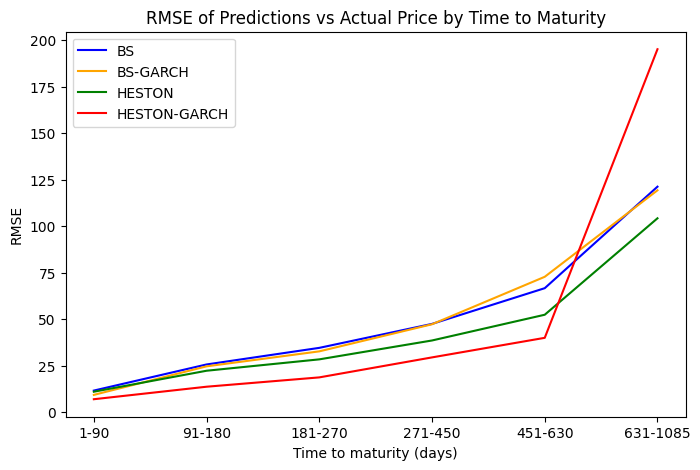

In [29]:
# Recreate figure 9 by plotting RMSE per dte bin

plt.figure(figsize=(8, 5))
plt.plot(bs_rmse_per_dte_bin.index, bs_rmse_per_dte_bin.values, linestyle="-", color="blue", label="BS")
plt.plot(bs_gg_rmse_per_dte_bin.index, bs_gg_rmse_per_dte_bin.values, linestyle="-", color="orange", label="BS-GARCH")
plt.plot(heston_rmse_per_dte_bin.index, heston_rmse_per_dte_bin.values, linestyle="-", color="green", label="HESTON")
plt.plot(heston_gg_rmse_per_dte_bin.index, heston_gg_rmse_per_dte_bin.values, linestyle="-", color="red", label="HESTON-GARCH")

plt.xlabel("Time to maturity (days)")
plt.ylabel("RMSE")
plt.title("RMSE of Predictions vs Actual Price by Time to Maturity")
plt.legend()
plt.show()

## RMSE by Moneyness (Figure 10)

In [30]:
# Now I'm going to work on recreating figure 10, RMSE of predictions sorted by moneyness

# Moneyness = S_0 / K, or Underlying_Last / Strike_Price
df["MONEYNESS"] = df["UNDERLYING_LAST"] / df["STRIKE"]

moneyness_bins = [0.5, 0.6, 0.7, 0.95, 1.05, 1.15, 1.5, 4.0, 8.0, 42.0]
moneyness_labels = ["0.5-0.6", "0.6-0.7", "0.7-0.95", "0.95-1.05", "1.05-1.15", "1.15-1.5", "1.5-4.0", "4.0-8.0", "8.0-42.0"]

df["MONEYNESS_BIN"] = pd.cut(df["MONEYNESS"], bins=moneyness_bins, labels=moneyness_labels, right=True)

def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))

# Compute the per bin RMSE
bs_rmse_per_moneyness_bin = df.groupby("MONEYNESS_BIN").apply(lambda x: rmse(x["BS_PRICE"], x["ACTUAL_PRICE"]))
bs_gg_rmse_per_moneyness_bin = df.groupby("MONEYNESS_BIN").apply(lambda x: rmse(x["BS_PRICE_GG"], x["ACTUAL_PRICE"]))
heston_rmse_per_moneyness_bin = df.groupby("MONEYNESS_BIN").apply(lambda x: rmse(x["HESTON_PRICE"], x["ACTUAL_PRICE"]))
heston_gg_rmse_per_moneyness_bin = df.groupby("MONEYNESS_BIN").apply(lambda x: rmse(x["HESTON_PRICE_GG"], x["ACTUAL_PRICE"]))


print(bs_rmse_per_moneyness_bin)
print(bs_gg_rmse_per_moneyness_bin)
print(heston_rmse_per_moneyness_bin)
print(heston_gg_rmse_per_moneyness_bin)

C:\Users\Benjamin\AppData\Local\Temp\ipykernel_16264\1001250215.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bs_rmse_per_moneyness_bin = df.groupby("MONEYNESS_BIN").apply(lambda x: rmse(x["BS_PRICE"], x["ACTUAL_PRICE"]))
C:\Users\Benjamin\AppData\Local\Temp\ipykernel_16264\1001250215.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bs_rmse_per_moneyness_bin = df.groupby("MONEYNESS_BIN").apply(lambda x: rmse(x["BS_PRICE"], x["ACTUAL_PRICE"]))
C:\Users\Benjamin\AppData\Local\Temp\ipykernel_16264\1001250

MONEYNESS_BIN
0.5-0.6      22.365458
0.6-0.7      32.855292
0.7-0.95     39.249753
0.95-1.05    23.357562
1.05-1.15    16.516680
1.15-1.5     12.626854
1.5-4.0      32.640581
4.0-8.0      76.345684
8.0-42.0     95.554185
dtype: float64
MONEYNESS_BIN
0.5-0.6      23.242990
0.6-0.7      32.142617
0.7-0.95     36.684079
0.95-1.05    21.083930
1.05-1.15    19.586402
1.15-1.5     14.568270
1.5-4.0      32.629684
4.0-8.0      76.346173
8.0-42.0     95.554186
dtype: float64
MONEYNESS_BIN
0.5-0.6       7.717708
0.6-0.7      14.640734
0.7-0.95     28.616547
0.95-1.05    20.627753
1.05-1.15    13.626701
1.15-1.5     13.030491
1.5-4.0      33.454411
4.0-8.0      76.367267
8.0-42.0     95.554644
dtype: float64
MONEYNESS_BIN
0.5-0.6      85.952476
0.6-0.7      88.224590
0.7-0.95     26.509868
0.95-1.05    17.006455
1.05-1.15    15.913477
1.15-1.5     15.329313
1.5-4.0      33.428024
4.0-8.0      76.280050
8.0-42.0     95.591085
dtype: float64


C:\Users\Benjamin\AppData\Local\Temp\ipykernel_16264\1001250215.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  heston_gg_rmse_per_moneyness_bin = df.groupby("MONEYNESS_BIN").apply(lambda x: rmse(x["HESTON_PRICE_GG"], x["ACTUAL_PRICE"]))


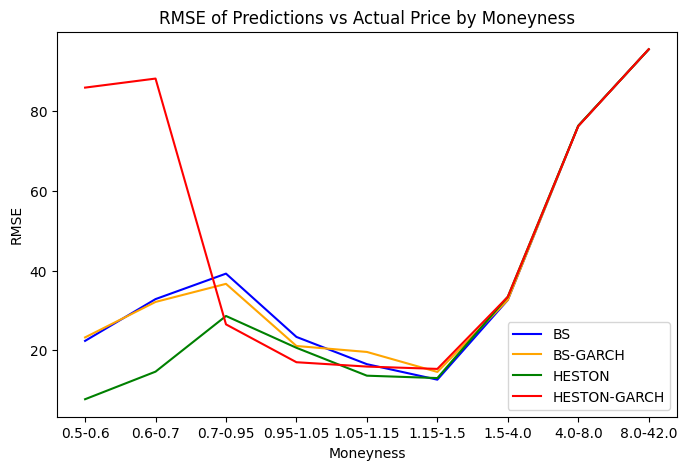

In [31]:
# Recreate figure 10 by plotting RMSE per moneyness bin

plt.figure(figsize=(8, 5))
plt.plot(bs_rmse_per_moneyness_bin.index, bs_rmse_per_moneyness_bin.values, linestyle="-", color="blue", label="BS")
plt.plot(bs_gg_rmse_per_moneyness_bin.index, bs_gg_rmse_per_moneyness_bin.values, linestyle="-", color="orange", label="BS-GARCH")
plt.plot(heston_rmse_per_moneyness_bin.index, heston_rmse_per_moneyness_bin.values, linestyle="-", color="green", label="HESTON")
plt.plot(heston_gg_rmse_per_moneyness_bin.index, heston_gg_rmse_per_moneyness_bin.values, linestyle="-", color="red", label="HESTON-GARCH")

plt.xlabel("Moneyness")
plt.ylabel("RMSE")
plt.title("RMSE of Predictions vs Actual Price by Moneyness")
plt.legend()
plt.show()

In [32]:
# Performance metrics for BS
performance_metrics = calculate_pimentel_metrics(y_true = df["ACTUAL_PRICE"], y_pred = df["BS_PRICE"])
pass

Month by Month Results to add to Results Summary

In [34]:
month_idx = 1
year = 2023

models = ["BS_PRICE", "BS_PRICE_GG", "HESTON_PRICE", "HESTON_PRICE_GG"]

month_names = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

results_dict = {model: [] for model in models} # Dict of dataframes (converted later)

while month_idx < 13:
    start = f"{year}-{month_idx:02d}-01"

    if month_idx == 12:
        end = f"{year + 1}-01-01"
    else:
        end = f"{year}-{month_idx + 1:02d}-01"

    df_month = df[(df["QUOTE_DATE"] >= start) & (df["QUOTE_DATE"] < end)]

    pass


    for model in models:
        actual = df_month["ACTUAL_PRICE"]
        pred = df_month[model]
        
        month_rmse = rmse(pred, actual)
        month_mae = np.mean(np.abs(actual - pred))
        month_mse = np.mean((actual - pred) ** 2)
        month_theil_u1 = calculate_pimentel_metrics(actual, pred)["theil_u1"]

        model_clean_name = model.replace("_PRICE", "")

        results_dict[model].append({
            "month": month_idx,
            "month_name": month_names[month_idx - 1],
            "rmse": month_rmse,
            "mae": month_mae,
            "mse": month_mse,
            "theil_u1": month_theil_u1,
            "model": model_clean_name
        })
    
    pass







    month_idx += 1


for model in models:
    results_dict[model] = pd.DataFrame(results_dict[model])

for key in results_dict:
    current = results_dict[key]
    pass